In [1]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
import itertools
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
import lightgbm as lgb
from prophet import Prophet

import pickle

# pd.set_option('display.max_columns', None) 
# pd.set_option('display.width', 1000)    

In [2]:
df = pd.read_csv('data/processed_tt.csv')
df = df[df['N'] != 'N']
df = df[df['date_group'] < '2025-02-01 00:00:00']

df.loc[:, 'N'] = df['N'].astype(float).astype(int)
df.loc[:, 'date_group'] = pd.to_datetime(df['date_group'])
df.loc[:, 'active_couriers_count'] = df['active_couriers_count'].astype(int)

# фильтр москва
tt_df = pd.read_excel('ТТ.xlsx')
df = df.merge(tt_df[['N', 'name_TT', 'Статус', 'tt_format_rasp', 'region_tt', 'Date_Open']], on=['N'], how='left')
df = df[df['region_tt'] == 'Москва']

C:\Users\shkur\AppData\Local\Temp\ipykernel_8024\3385064007.py:1: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed_tt.csv')


### Подготовка к прогнозу

In [3]:
df = df[['N', 'date_group', 'active_couriers_count']]
df = df.sort_values(['N', 'date_group'])
unique_N = df['N'].unique()

# Порог для определения "длительного" периода с нулями (7 дней)
threshold = pd.Timedelta(days=7)
def remove_initial_zero_period(group):
    # Находим первую строку, где active_couriers_count не равен 0
    non_zero = group[group['active_couriers_count'] != 0]
    if non_zero.empty:
        return group
    first_non_zero_time = non_zero.iloc[0]['date_group']
    first_time = group.iloc[0]['date_group']
    # Если период до первого ненулевого значения превышает порог, удаляем этот период
    if first_non_zero_time - first_time > threshold:
        group = group[group['date_group'] >= first_non_zero_time]
    return group
df_filtered = df.groupby('N', group_keys=False).apply(remove_initial_zero_period)
df_filtered = df_filtered.groupby(['N', 'date_group'], as_index=False).last()
df_filtered


df_filtered = df_filtered.sort_values(['N', 'date_group'])
df_filtered['active_couriers_count'] = df_filtered['active_couriers_count'].astype(int)

selected_n = df_filtered['N'].unique()[0]
df_n = df_filtered[df_filtered['N'] == selected_n].copy()
df_n = df_n.set_index('date_group').asfreq('15min')
df_n


C:\Users\shkur\AppData\Local\Temp\ipykernel_8024\3748753817.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df.groupby('N', group_keys=False).apply(remove_initial_zero_period)


,N,active_couriers_count
date_group,,
2024-01-03 11:00:00,4723,0
2024-01-03 11:15:00,4723,0
2024-01-03 11:30:00,4723,0
2024-01-03 11:45:00,4723,0
2024-01-03 12:00:00,4723,0
...,...,...
2025-01-31 22:45:00,4723,4
2025-01-31 23:00:00,4723,6
2025-01-31 23:15:00,4723,4


### визуализация колво активных курьеров по ТТ

In [ ]:
# Выбираем первое значение N для начального отображения
initial_n = unique_N[0]

# Создаем фигуру и добавляем трейс для каждого значения N, но показываем только первый
fig = go.Figure()
for n in unique_N:
    df_n = df[df['N'] == n]
    visible = True if n == initial_n else False
    fig.add_trace(go.Scatter(
        x=df_n['date_group'],
        y=df_n['active_couriers_count'],
        mode='lines+markers',
        name=f'N = {n}',
        visible=visible
    ))

# Создаем кнопки для выпадающего меню
buttons = []
for i, n in enumerate(unique_N):
    visible_arr = [False] * len(unique_N)
    visible_arr[i] = True  # делаем видимым только выбранное значение
    buttons.append(dict(
        label=str(n),
        method="update",
        args=[{"visible": visible_arr},
              {"title": f"Временной ряд active_couriers_count для N = {n}"}]
    ))
# Обновляем макет графика
fig.update_layout(
    updatemenus=[dict(
        active=0,
        buttons=buttons,
        x=1.1,  # положение меню по оси X
        y=1
    )],
    title=f"Временной ряд active_couriers_count для N = {initial_n}",
    xaxis_title="Дата и время (интервал 15 минут)",
    yaxis_title="active_couriers_count",
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1 день",
                     step="day",
                     stepmode="backward"),
                dict(count=7,
                     label="7 дней",
                     step="day",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    )
)

fig.show()


### функции для моделей

In [4]:
def compute_metrics(actual, forecast):
    mae = mean_absolute_error(actual, forecast)
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    return mae, rmse

def save_to_csv(result, output_file, header):
    result_df = pd.DataFrame([result])
    with open(output_file, 'a') as f:
        result_df.to_csv(f, header=header, index=False)

#### xgboost

In [ ]:
def prepare_multi_step_data(df, target_source_col, input_steps, forecast_steps, feature_cols):
    """
    Формирует обучающие примеры для многовыходного прогнозирования с использованием скользящего окна.

    Параметры:
    df               : DataFrame с индексом типа datetime.
    target_source_col: Имя столбца, по которому необходимо сделать прогноз (например, 'active_couriers_count').
    input_steps      : Количество предыдущих интервалов, используемых в качестве входных данных.
    forecast_steps   : Количество будущих интервалов для прогнозирования.
    feature_cols     : Список имён признаков. Если пуст, используется [target_source_col].

    Возвращает:
    X_df, Y, sample_times – 
        X_df         : DataFrame с входными признаками (с корректными именами столбцов),
        Y            : numpy-массив целевых векторов,
        sample_times : numpy-массив соответствующих временных меток.
    """

    if not feature_cols:
        feature_cols = [target_source_col]
    
    X, Y, sample_times = [], [], []
    for i in range(input_steps, len(df) - forecast_steps + 1):
        window = df.iloc[i - input_steps:i][feature_cols].values.flatten()
        X.append(window)
        Y.append(df[target_source_col].iloc[i:i + forecast_steps].values)
        sample_times.append(df.index[i])
    col_names = []
    for feat in feature_cols:
        for lag in range(input_steps, 0, -1):
            col_names.append(f"{feat}_lag_{lag}")
    X_df = pd.DataFrame(np.array(X), columns=col_names, index=sample_times)
    return X_df, np.array(Y), np.array(sample_times)

def train_xgboost_multi_step_model(df, target_source_col, input_steps, forecast_steps, split_date, feature_cols, max_evals=50, plot=True):
    """
    Обучает модель многовыходного прогнозирования с использованием XGBoost (обёрнутой в MultiOutputRegressor).

    Параметры:
    df               : DataFrame с индексом типа datetime и (опционально) дополнительными признаками.
    target_source_col: Имя столбца, по которому производится прогноз (например, 'active_couriers_count').
    input_steps      : Количество предыдущих интервалов, используемых в качестве входных данных.
    forecast_steps   : Количество будущих интервалов для прогнозирования (например, 4 для +15, +30, +45, +60 минут).
    split_date       : Дата (в виде строки или datetime), по которой данные делятся на обучающую и тестовую выборки.
    feature_cols     : Список имён столбцов-признаков. Если пуст, используется [target_source_col].
    max_evals        : Максимальное количество итераций оптимизации с помощью hyperopt.
    plot             : Если True, строится график непрерывного прогноза (используя прогноз T+15 для каждого окна).

    Возвращает:
    final_model, sample_times, X_train, Y_train, X_test, Y_test, forecast_series
    """

    X_all, Y_all, sample_times = prepare_multi_step_data(df, target_source_col, input_steps, forecast_steps, feature_cols)
    
    split_date = pd.to_datetime(split_date)
    train_mask = sample_times < split_date
    test_mask  = sample_times >= split_date
    X_train, Y_train = X_all.loc[train_mask], Y_all[train_mask]
    X_test,  Y_test  = X_all.loc[test_mask], Y_all[test_mask]
    
    X_train_part, X_valid, Y_train_part, Y_valid = train_test_split(X_train, Y_train, test_size=0.2, shuffle=False)
    
    def objective(params):
        params['max_depth'] = int(params['max_depth'])
        params['n_estimators'] = int(params['n_estimators'])
        params['min_child_weight'] = int(params['min_child_weight'])
        
        model = xgb.XGBRegressor(
            max_depth=params['max_depth'],
            learning_rate=params['learning_rate'],
            n_estimators=params['n_estimators'],
            subsample=params['subsample'],
            colsample_bytree=params['colsample_bytree'],
            min_child_weight=params['min_child_weight'],
            gamma=params['gamma'],
            reg_alpha=params['reg_alpha'],
            reg_lambda=params['reg_lambda'],
            tree_method=params['tree_method'],
            objective='reg:squarederror',
            random_state=42,
            n_jobs=-1
        )
        multi_model = MultiOutputRegressor(model)
        multi_model.fit(X_train_part, Y_train_part)
        preds = multi_model.predict(X_valid)
        rmse = np.sqrt(mean_squared_error(Y_valid, preds))
        return {'loss': rmse, 'status': STATUS_OK}
    
    space = {
        'max_depth': hp.quniform('max_depth', 3, 15, 1),
        'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
        'n_estimators': hp.quniform('n_estimators', 50, 1000, 1),
        'subsample': hp.uniform('subsample', 0.5, 1.0),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
        'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
        'gamma': hp.uniform('gamma', 0, 5),
        'reg_alpha': hp.loguniform('reg_alpha', np.log(0.0001), np.log(1)),
        'reg_lambda': hp.loguniform('reg_lambda', np.log(0.0001), np.log(1)),
        'tree_method': hp.choice('tree_method', ['auto', 'exact', 'approx', 'hist'])
    }
    
    trials = Trials()
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=max_evals,
                trials=trials, rstate=np.random.default_rng(42))
    
    tree_methods = ['auto', 'exact', 'approx', 'hist']
    best_params = {
        'max_depth': int(best['max_depth']),
        'learning_rate': best['learning_rate'],
        'n_estimators': int(best['n_estimators']),
        'subsample': best['subsample'],
        'colsample_bytree': best['colsample_bytree'],
        'min_child_weight': int(best['min_child_weight']),
        'gamma': best['gamma'],
        'reg_alpha': best['reg_alpha'],
        'reg_lambda': best['reg_lambda'],
        'tree_method': tree_methods[best['tree_method']]
    }
    print("Best hyperparameters for XGBoost multi-step:", best_params)
    
    final_model_base = xgb.XGBRegressor(
        **best_params,
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    )
    final_model = MultiOutputRegressor(final_model_base)
    final_model.fit(X_train, Y_train)
    
    preds_test = final_model.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(Y_test, preds_test))
    print("RMSE on test set:", rmse_test)
    
    forecast_values = preds_test[:, 0]
    forecast_times = pd.to_datetime(X_test.index) + pd.Timedelta(minutes=15)
    forecast_series = pd.Series(forecast_values, index=forecast_times)

    if plot:
        plt.figure(figsize=(14,6))
        plt.plot(df[target_source_col].loc[forecast_series.index[0]:], label='Actual')
        plt.plot(forecast_series, label='Forecast (T+15)', color='red')
        plt.title('Continuous Forecast (T+15) over Test Period')
        plt.xlabel('Time')
        plt.ylabel('Active couriers count')
        plt.legend()
        plt.show()
    
    return final_model, sample_times, X_train, Y_train, X_test, Y_test, forecast_series




#### lightbm

In [10]:
def prepare_multi_step_data(df, target_source_col, input_steps, forecast_steps, feature_cols):
    """
    Формирует обучающие примеры для мультивыходного прогнозирования с использованием скользящего окна.
    
    Параметры:
      df               - исходный DataFrame с индексом типа datetime.
      target_source_col- имя столбца, содержащего исходный ряд (например, 'active_couriers_count').
      input_steps      - число предыдущих интервалов для формирования входа.
      forecast_steps   - число шагов для прогнозирования.
      feature_cols     - список признаков для формирования входа. Если список пуст, то используется [target_source_col].
      
    Возвращает:
      X_df, Y, sample_times - X_df: DataFrame с входными признаками (с именами столбцов),
                              Y: numpy-массив целевых векторов,
                              sample_times: массив временных меток для каждого примера.
    """
    # Если список признаков пуст, используем по умолчанию target_source_col
    if not feature_cols:
        feature_cols = [target_source_col]
    
    X, Y, sample_times = [], [], []
    for i in range(input_steps, len(df) - forecast_steps + 1):
        # Для каждого примера собираем окно для каждого признака и объединяем их в один вектор
        window = df.iloc[i - input_steps:i][feature_cols].values.flatten()
        X.append(window)
        Y.append(df[target_source_col].iloc[i:i + forecast_steps].values)
        sample_times.append(df.index[i])
    
    # Формируем имена столбцов: для каждого признака для каждого шага лага
    col_names = []
    for feat in feature_cols:
        for lag in range(input_steps, 0, -1):
            col_names.append(f"{feat}_lag_{lag}")
    X_df = pd.DataFrame(np.array(X), columns=col_names, index=sample_times)
    return X_df, np.array(Y), np.array(sample_times)

def train_lightgbm_multi_step_model(df, target_source_col, input_steps, forecast_steps, split_date, feature_cols, max_evals=50, plot=True):
    """
    Обучает мультивыходную модель LightGBM (через MultiOutputRegressor) для прогнозирования нескольких шагов вперед.
    
    Параметры:
      df               - исходный DataFrame с индексом типа datetime.
      target_source_col- имя столбца, содержащего исходный временной ряд (например, 'active_couriers_count').
      input_steps      - число предыдущих интервалов для входа.
      forecast_steps   - число шагов для прогнозирования (например, 4: +15, +30, +45, +60 мин).
      split_date       - дата разделения на обучающую и тестовую выборки (например, '2024-10-01').
      feature_cols     - список признаков для формирования входа. Если пуст, используется [target_source_col].
      max_evals        - число итераций оптимизации hyperopt.
      plot             - если True, строит график непрерывного прогноза.
    
    Возвращает:
      final_model, sample_times, X_train, Y_train, X_test, Y_test, forecast_series
    """
    # Подготовка обучающих примеров; X_all будет DataFrame с корректными именами столбцов.
    X_all, Y_all, sample_times = prepare_multi_step_data(df, target_source_col, input_steps, forecast_steps, feature_cols)
    
    # Разбиваем выборку по времени на основе sample_times
    split_date = pd.to_datetime(split_date)
    train_mask = sample_times < split_date
    test_mask  = sample_times >= split_date
    X_train, Y_train = X_all.loc[train_mask], Y_all[train_mask]
    X_test,  Y_test  = X_all.loc[test_mask], Y_all[test_mask]
    
    # Разбиваем тренировочную выборку для оптимизации гиперпараметров
    X_train_part, X_valid, Y_train_part, Y_valid = train_test_split(
        X_train, Y_train, test_size=0.2, shuffle=False
    )
    
    # Определяем objective-функцию для hyperopt
    def objective(params):
        params['max_depth'] = int(params['max_depth'])
        params['n_estimators'] = int(params['n_estimators'])
        params['min_child_samples'] = int(params['min_child_samples'])
        
        base_model = lgb.LGBMRegressor(
            max_depth=params['max_depth'],
            learning_rate=params['learning_rate'],
            n_estimators=params['n_estimators'],
            subsample=params['subsample'],
            colsample_bytree=params['colsample_bytree'],
            min_child_samples=params['min_child_samples'],
            reg_alpha=params['reg_alpha'],
            reg_lambda=params['reg_lambda'],
            objective='regression',
            random_state=42,
            n_jobs=-1,
            verbosity=-1
        )
        model = MultiOutputRegressor(base_model)
        model.fit(X_train_part, Y_train_part)
        preds = model.predict(X_valid)
        
        rmse = np.sqrt(mean_squared_error(Y_valid, preds))
        return {'loss': rmse, 'status': STATUS_OK}
    
    # Расширенное пространство гиперпараметров
    space = {
        'max_depth': hp.quniform('max_depth', 3, 15, 1),
        'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
        'n_estimators': hp.quniform('n_estimators', 50, 500, 1),
        'subsample': hp.uniform('subsample', 0.5, 1.0),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
        'min_child_samples': hp.quniform('min_child_samples', 1, 10, 1),
        'reg_alpha': hp.loguniform('reg_alpha', np.log(0.0001), np.log(10)),
        'reg_lambda': hp.loguniform('reg_lambda', np.log(0.0001), np.log(10))
    }
    
    trials = Trials()
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=max_evals,
                trials=trials, rstate=np.random.default_rng(42))
    best_params = {
        'max_depth': int(best['max_depth']),
        'learning_rate': best['learning_rate'],
        'n_estimators': int(best['n_estimators']),
        'subsample': best['subsample'],
        'colsample_bytree': best['colsample_bytree'],
        'min_child_samples': int(best['min_child_samples']),
        'reg_alpha': best['reg_alpha'],
        'reg_lambda': best['reg_lambda']
    }
    print("Best hyperparameters for multi-step LightGBM:", best_params)
    
    base_model_final = lgb.LGBMRegressor(
        **best_params,
        objective='regression',
        random_state=42,
        n_jobs=-1,
        verbosity=-1
    )
    final_model = MultiOutputRegressor(base_model_final)
    final_model.fit(X_train, Y_train)
    
    preds_test = final_model.predict(X_test)
    mae, rmse = compute_metrics(Y_test, preds_test)
    print(f"RMSE on test set: {rmse}, MAE: {mae}")
    
    # Для построения непрерывного прогноза, берем первый прогноз (T+15) каждого тестового окна,
    # сдвигаем временные метки на 15 минут вперед и строим график вместе с реальным рядом.
    forecast_values = preds_test[:, 0]  # прогноз на T+15 для каждого окна
    forecast_times = pd.to_datetime(X_test.index) + pd.Timedelta(minutes=15)
    forecast_series = pd.Series(forecast_values, index=forecast_times)
    
    plt.figure(figsize=(14,6))
    # Построим полный временной ряд с момента начала прогноза
    plt.plot(df[target_source_col].loc[forecast_series.index[0]:], label='Actual')
    plt.plot(forecast_series, label='Forecast (T+15)', color='red')
    plt.title('Continuous Forecast (T+15) over Test Period')
    plt.xlabel('Time')
    plt.ylabel('Active couriers count')
    plt.legend()
    plt.show()

    # Теперь переобучаем модель на всех данных (X_all, Y_all)
    # base_model_final = lgb.LGBMRegressor(
    #     **best_params,
    #     objective='regression',
    #     random_state=42,
    #     n_jobs=-1,
    #     verbosity=-1
    # )
    # final_model_full = MultiOutputRegressor(base_model_final)
    # final_model_full.fit(X_all, Y_all)
    # return final_model_full, sample_times, Y_test, preds_test, forecast_series, mae, rmse
    
    
    return final_model, sample_times, Y_test, preds_test, forecast_series, mae, rmse

#### prophet

In [9]:
def train_prophet_model_with_exog(df, target_source_col, split_date, extra_regressors=None, plot=True):
    """
    Обучает модель Prophet с использованием исторических данных и выполняет прогноз на тестовой выборке.
    После вычисления метрик на тестовой выборке модель переобучается на полном датасете.

    Параметры:
    df               : DataFrame с индексом типа datetime и всеми необходимыми столбцами.
    target_source_col: Имя столбца с целевыми значениями (например, 'active_couriers_count').
    split_date       : Дата (в виде строки или datetime), используемая для разделения данных на обучающую и тестовую выборки.
    extra_regressors : Список имён дополнительных регрессоров, которые будут использоваться. Эти столбцы должны присутствовать в df.
    plot             : Если True, строится график прогноза вместе с данными обучающей и тестовой выборок.

    Возвращает:
    final_model     : Итоговая модель Prophet, переобученная на полном датасете.
    forecast_df     : DataFrame с прогнозом, вычисленным на тестовой выборке.
    metrics         : Кортеж (actual, forecast, mae, rmse), вычисленный на тестовой выборке.
    """

    df_prophet = df.reset_index().rename(columns={'date_group': 'ds', target_source_col: 'y'})
    df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
    
    # Проверяем что все фичи (регрессоры) есть
    if extra_regressors:
        missing = [reg for reg in extra_regressors if reg not in df_prophet.columns]
        if missing:
            raise ValueError(f"Missing regressors in the dataframe: {missing}")
    
    # Разделение на train, test
    split_date = pd.to_datetime(split_date)
    train_df = df_prophet[df_prophet['ds'] < split_date].copy()
    test_df  = df_prophet[df_prophet['ds'] >= split_date].copy()
    forecast_steps = len(test_df)
    
    # Инициализация моделя
    model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=False)
    if extra_regressors:
        for reg in extra_regressors:
            model.add_regressor(reg)
    
  
    model.fit(train_df)
    forecast_df = model.predict(test_df)
    
    # Считаем метрики
    if 'y' in test_df.columns:
        actual = test_df['y'].iloc[:forecast_steps].values
        yhat = forecast_df['yhat'].iloc[:forecast_steps].values
        mae, rmse = compute_metrics(actual, yhat)
        print(f"MAE: {mae:.3f}, RMSE: {rmse:.3f}")
    else:
        actual, yhat, mae, rmse = None, None, None, None
    
    if plot:
        plt.figure(figsize=(14,6))
        plt.plot(train_df['ds'], train_df['y'], label='Train')
        plt.plot(test_df['ds'], test_df['y'], label='Test')
        plt.plot(forecast_df['ds'], forecast_df['yhat'], label='Forecast', color='red')
        plt.fill_between(forecast_df['ds'], forecast_df['yhat_lower'], forecast_df['yhat_upper'],
                         color='pink', alpha=0.3, label='Confidence Interval')
        plt.title('Prophet Forecast with Exogenous Regressors (Test Data)')
        plt.xlabel('Time')
        plt.ylabel(target_source_col)
        plt.legend()
        plt.show()
    
    # Переобучаем на все данные
    # final_model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=False)
    # if extra_regressors:
    #     for reg in extra_regressors:
    #         final_model.add_regressor(reg)
    # final_model.fit(df_prophet)
    # return final_model, actual, yhat, mae, rmse
    return model, actual, yhat, mae, rmse

## Прогноз без фичей только для одного ТТ

### lightgbm

100%|██████████| 50/50 [00:35<00:00,  1.41trial/s, best loss: 2.553289254167801] 
Best hyperparameters for multi-step LightGBM: {'max_depth': 14, 'learning_rate': np.float64(0.04267476691618888), 'n_estimators': 96, 'subsample': np.float64(0.5689557797511523), 'colsample_bytree': np.float64(0.6260144706057186), 'min_child_samples': 4, 'reg_alpha': np.float64(0.6281831102869511), 'reg_lambda': np.float64(4.974817648448197)}
RMSE on test set: 2.562869645786391, MAE: 1.932613602346268


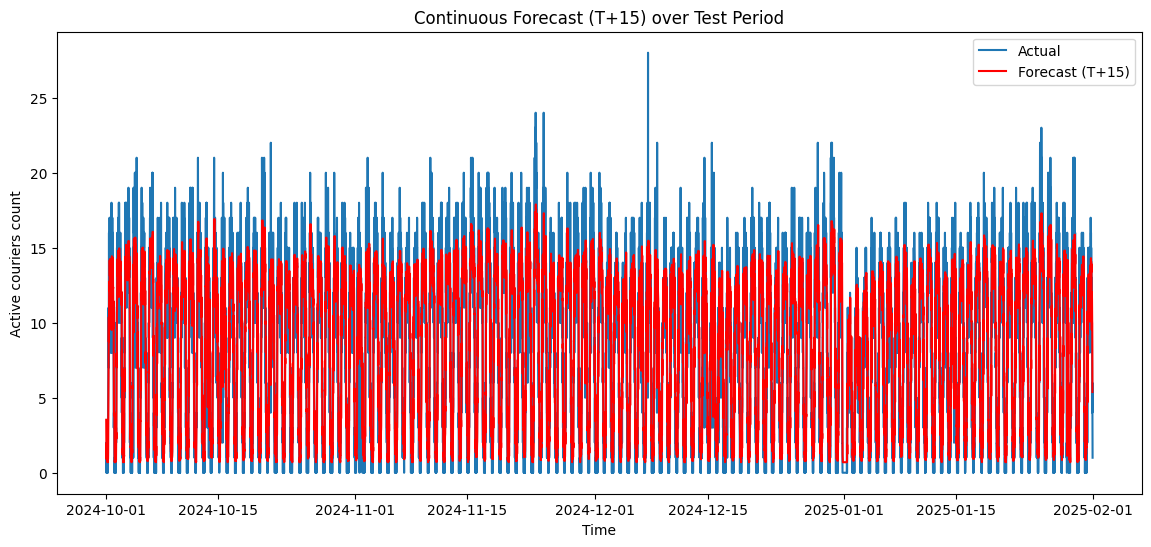

2024-10-01 00:15:00     3.529027
2024-10-01 00:30:00     2.275586
2024-10-01 00:45:00     1.525172
2024-10-01 01:00:00     1.931525
2024-10-01 01:15:00     0.928753
                         ...    
2025-01-31 22:15:00    10.584479
2025-01-31 22:30:00    10.074860
2025-01-31 22:45:00     9.964090
2025-01-31 23:00:00     7.768828
2025-01-31 23:15:00     5.382317
Length: 11805, dtype: float64

In [ ]:
split_date = pd.to_datetime('2024-10-01')
df_n_light = df_n.copy()
input_steps = 4      
forecast_steps = 4   
features = []
final_model, sample_times, Y_test, pred_test, forecast_series, mae, rmse = train_lightgbm_multi_step_model(
    df_n_light, 'active_couriers_count', input_steps, forecast_steps, split_date, features, max_evals=50, plot=True
)

### xgboost

100%|██████████| 50/50 [03:19<00:00,  3.99s/trial, best loss: 2.55152178963715]  
Best hyperparameters for XGBoost multi-step: {'max_depth': 5, 'learning_rate': np.float64(0.010489757271994056), 'n_estimators': 441, 'subsample': np.float64(0.8361089698400326), 'colsample_bytree': np.float64(0.7597018091311807), 'min_child_weight': 8, 'gamma': np.float64(3.7640941015982676), 'reg_alpha': np.float64(0.03141149505270359), 'reg_lambda': np.float64(0.00010132536873730753), 'tree_method': 'hist'}
RMSE on test set: 2.5614948627421152


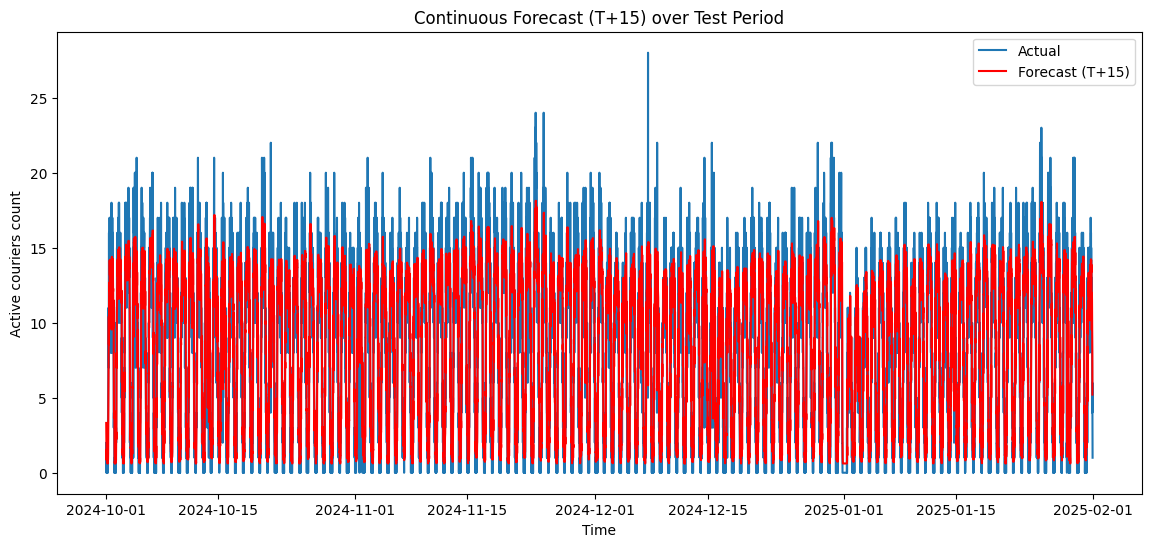

In [39]:
split_date = pd.to_datetime('2024-10-01')
df_n_xgb = df_n.copy()
features = []
input_steps = 4      
forecast_steps = 4   

final_model, sample_times, X_train, Y_train, X_test, Y_test, forecast_series = train_xgboost_multi_step_model(
    df_n_xgb, 'active_couriers_count', input_steps, forecast_steps, split_date, features, max_evals=50, plot=True
)

### prophet

21:55:31 - cmdstanpy - INFO - Chain [1] start processing
21:55:34 - cmdstanpy - INFO - Chain [1] done processing


MAE: 2.087, RMSE: 2.762


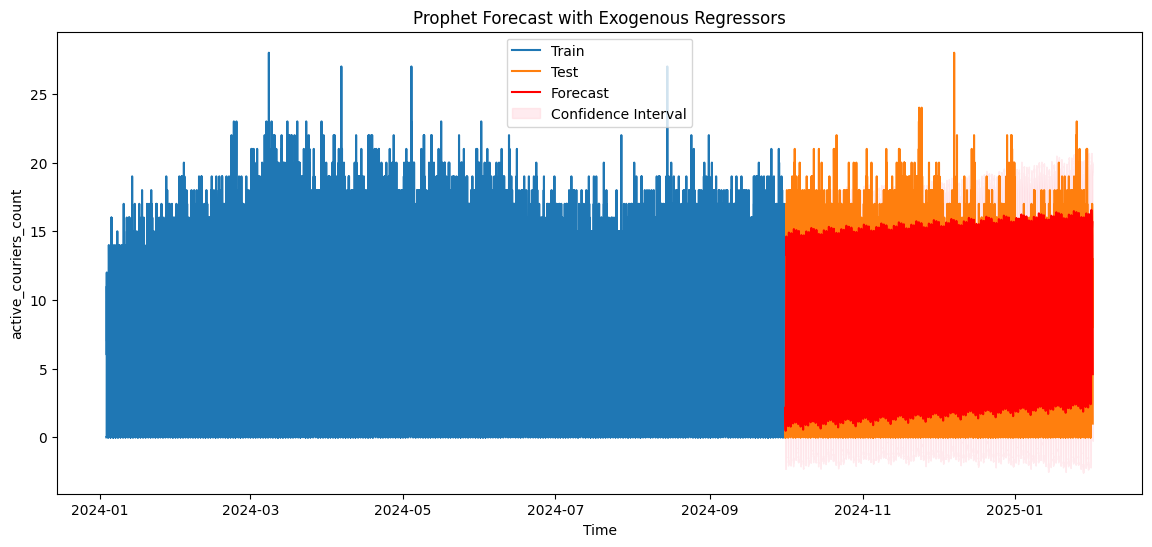

In [58]:
split_date = '2024-10-01'
df_n_light = df_n.copy()

exog_features = []

model, actual, yhat, mae, rmse = train_prophet_model_with_exog(df_n_light, 'active_couriers_count', split_date, extra_regressors=exog_features, plot=True)


## Добавляем фичи и попробуем в одном ДС

##### фичи

In [6]:
holidays = [
    "2024-01-01", "2024-01-02", "2024-01-03", "2024-01-04", "2024-01-05", "2024-01-06", 
    "2024-01-07", "2024-01-08", "2024-02-23", "2024-03-08", "2024-05-01", "2024-05-09", 
    "2024-06-12", "2024-11-04", "2024-10-05", "2024-11-24", "2024-03-31", "2024-02-20", 
    "2024-02-21", "2024-02-22", "2024-02-23", "2024-02-24", "2024-02-25", "2025-01-01", 
    "2025-01-02", "2025-01-03", "2025-01-04", "2025-01-05", "2025-01-06", "2025-01-07", 
    "2025-01-08", "2025-02-24", "2025-02-25", "2025-02-26", "2025-02-27", "2025-02-28", 
    "2025-03-01", "2025-02-23", "2025-03-08", "2025-04-20", "2025-05-01", "2025-05-09", 
    "2025-06-12", "2025-10-05", "2025-11-04", "2025-11-30" 
]

holidays_dates = pd.to_datetime(holidays)

def add_features(df):
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    df['dayofweek'] = df.index.dayofweek
    df['lag_4'] = df['active_couriers_count'].shift(4)
    df['lag_three_hours'] = df['active_couriers_count'].shift(1, freq='3h')
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['rolling_mean_1h'] = df['active_couriers_count'].shift(4).rolling(window=4).mean()
    df['rolling_std_1h'] = df['active_couriers_count'].shift(4).rolling(window=4).std()
    df['rolling_mean_3h'] = df['active_couriers_count'].shift(4).rolling(window=12).mean()
    df['rolling_std_3h'] = df['active_couriers_count'].shift(4).rolling(window=12).std()
    return df


### lightgbm

100%|██████████| 50/50 [03:12<00:00,  3.85s/trial, best loss: 2.0180610586440557]
Best hyperparameters for multi-step LightGBM: {'max_depth': 6, 'learning_rate': np.float64(0.011385984454937244), 'n_estimators': 289, 'subsample': np.float64(0.683222454185066), 'colsample_bytree': np.float64(0.5496885719455262), 'min_child_samples': 5, 'reg_alpha': np.float64(0.004292343785871919), 'reg_lambda': np.float64(0.008648442908463729)}
RMSE on test set: 2.129705971163296, MAE: 1.5795170063765513


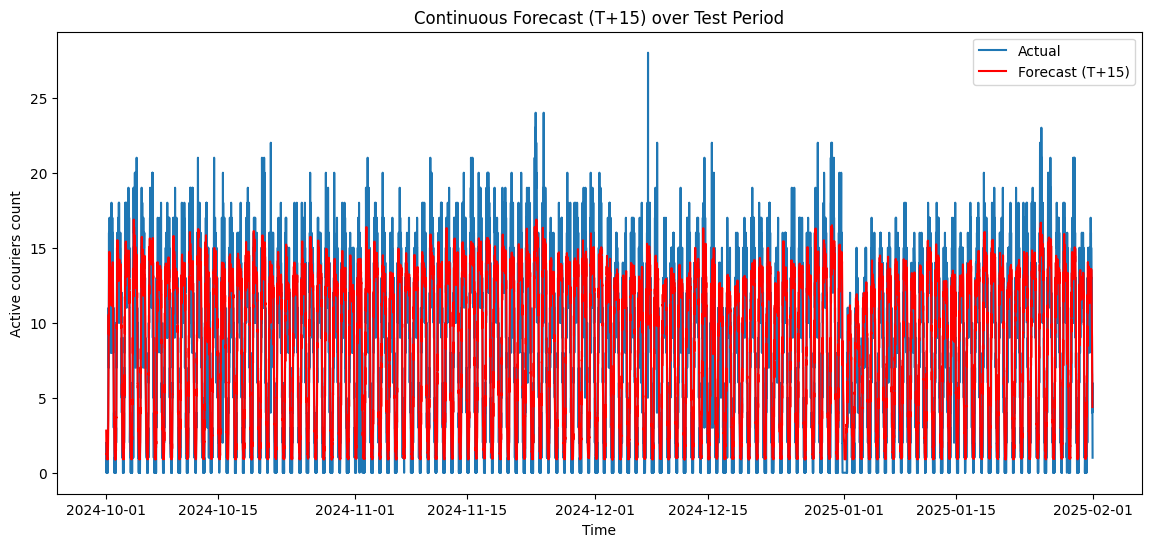

In [ ]:
split_date = pd.to_datetime('2024-10-01')
df_n_light = df_n.copy()
df_n_light = add_features(df_n_light)

# НЕ ПОМОГЛИ:
# df_n_light['lag_yesterday'] = df_n_light['active_couriers_count'].shift(1, freq='D')
# df_n_light['lag_week'] = df_n_light['active_couriers_count'].shift(1, freq='7D')
# df_n_light['lag_mean_3days'] = (
#     df_n_light['active_couriers_count'].shift(1, freq='D') +
#     df_n_light['active_couriers_count'].shift(2, freq='D') +
#     df_n_light['active_couriers_count'].shift(3, freq='D')
# ) / 3
# df_n_light['is_weekend'] = df_n_light['dayofweek'].isin([5, 6]).astype(int)
# df_n_light['hour_cos'] = np.cos(2 * np.pi * df_n_light['hour'] / 24)
# df_n_light['diff_1h_15_min'] = df_n_light['active_couriers_count'].shift(5) - df_n_light['active_couriers_count'].shift(4)
# df_n_light['is_holiday'] = pd.Series(df_n_light.index.date).isin(holidays_dates).astype(int).values

features = ['hour', 'minute', 'dayofweek', 'hour_sin', 
            'lag_three_hours', 'lag_4', 'rolling_mean_1h', 'rolling_std_1h',
            'rolling_mean_3h', 'rolling_std_3h']

input_steps = 4      
forecast_steps = 4   
final_model, sample_times, Y_test, pred_test, forecast_series, mae, rmse = train_lightgbm_multi_step_model(
    df_n_light, 'active_couriers_count', input_steps, forecast_steps, split_date, features, max_evals=50, plot=True
)


### xgboost

100%|██████████| 50/50 [08:42<00:00, 10.45s/trial, best loss: 2.0439408799372627]
Best hyperparameters for XGBoost multi-step: {'max_depth': 6, 'learning_rate': np.float64(0.011420624920207038), 'n_estimators': 437, 'subsample': np.float64(0.7370471568170598), 'colsample_bytree': np.float64(0.6713008333878093), 'min_child_weight': 4, 'gamma': np.float64(3.717566456141113), 'reg_alpha': np.float64(0.012333853989201456), 'reg_lambda': np.float64(0.0007946164700464254)}
RMSE on test set: 2.2048613287123793


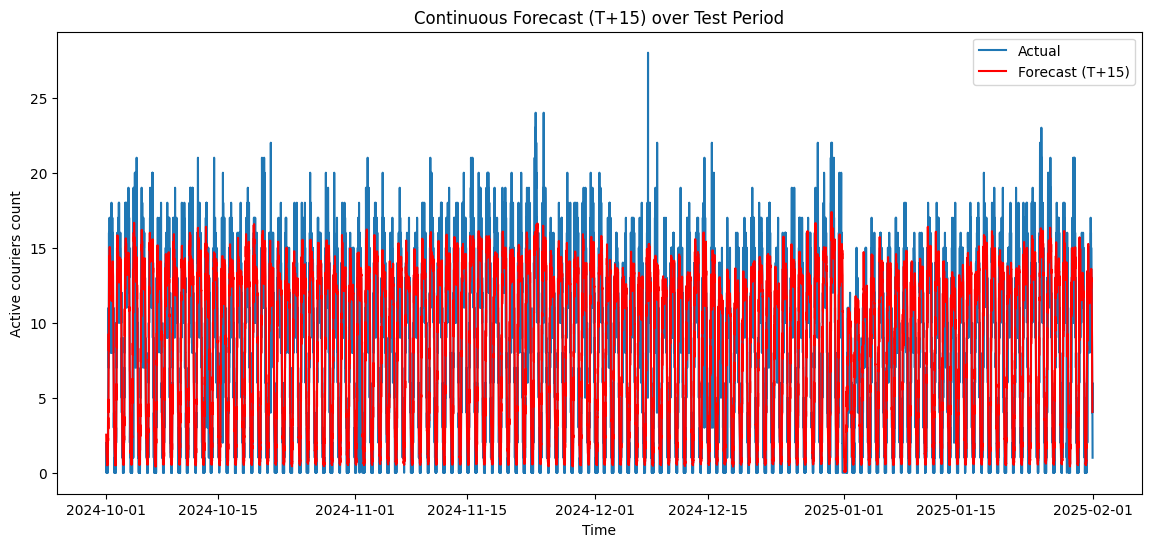

In [7]:
split_date = pd.to_datetime('2024-10-01')
df_n_xgb = df_n.copy()
df_n_xgb = add_features(df_n_xgb)

features = ['hour', 'minute', 'dayofweek', 'hour_sin', 
            'lag_three_hours', 'lag_4', 'rolling_mean_1h', 'rolling_std_1h',
            'rolling_mean_3h', 'rolling_std_3h']

input_steps = 4      
forecast_steps = 4   
final_model, sample_times, X_train, Y_train, X_test, Y_test, forecast_series = train_xgboost_multi_step_model(
    df_n_xgb, 'active_couriers_count', input_steps, forecast_steps, split_date, features, max_evals=50, plot=True
)

### prophet

12:42:08 - cmdstanpy - INFO - Chain [1] start processing
12:42:11 - cmdstanpy - INFO - Chain [1] done processing


MAE: 1.781, RMSE: 2.366


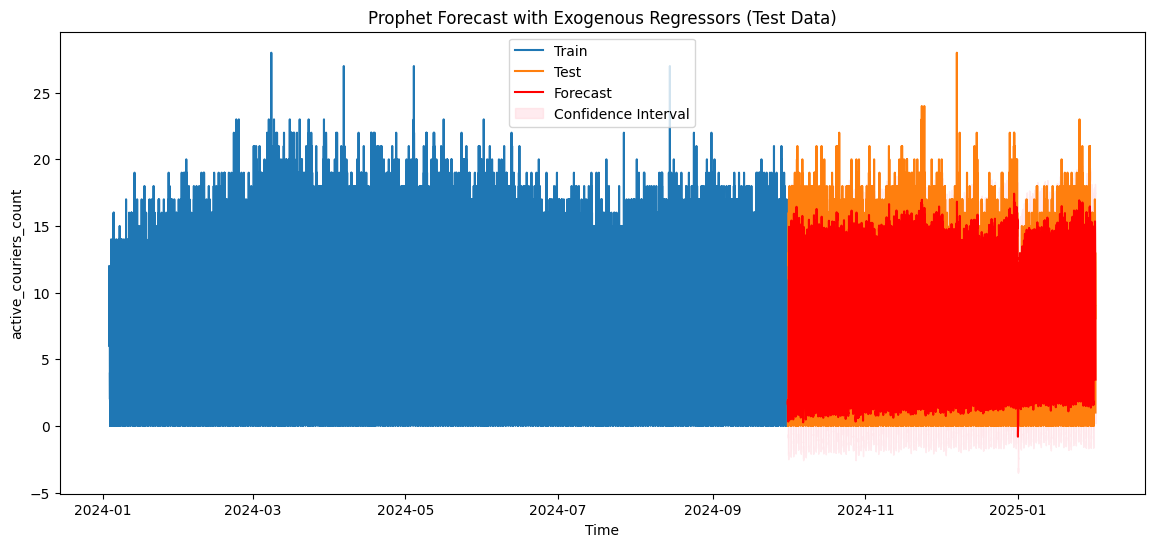

In [11]:
exog_features = ['hour', 'minute', 'dayofweek', 'hour_sin', 
                 'lag_three_hours', 'lag_4', 'rolling_mean_1h', 'rolling_std_1h',
                 'rolling_mean_3h', 'rolling_std_3h']

df_n_prophet = df_n.copy()
df_n_prophet = add_features(df_n_prophet)
df_n_prophet = df_n_prophet.dropna()
split_date = '2024-10-01'

model_prophet, actual, yhat, mae, rmse  = train_prophet_model_with_exog(df_n_prophet, 'active_couriers_count', split_date,
                                                           extra_regressors=exog_features, plot=True)

## Для каждого ДС выбираем метод (prophet vs lightgbm) на основе метрик

In [12]:
unique_N = df['N'].unique()
unique_N = unique_N[:5]
unique_N

array([4723, 4743, 4755, 4757, 4764], dtype=object)

Choosing method for 4723
100%|██████████| 50/50 [03:15<00:00,  3.91s/trial, best loss: 2.024986737003167] 
Best hyperparameters for multi-step LightGBM: {'max_depth': 14, 'learning_rate': np.float64(0.010021077124797084), 'n_estimators': 412, 'subsample': np.float64(0.7897940854001194), 'colsample_bytree': np.float64(0.5091749791014941), 'min_child_samples': 7, 'reg_alpha': np.float64(0.01959809480612366), 'reg_lambda': np.float64(0.004648035577874464)}
RMSE on test set: 2.1462638087655757, MAE: 1.5948737829765407


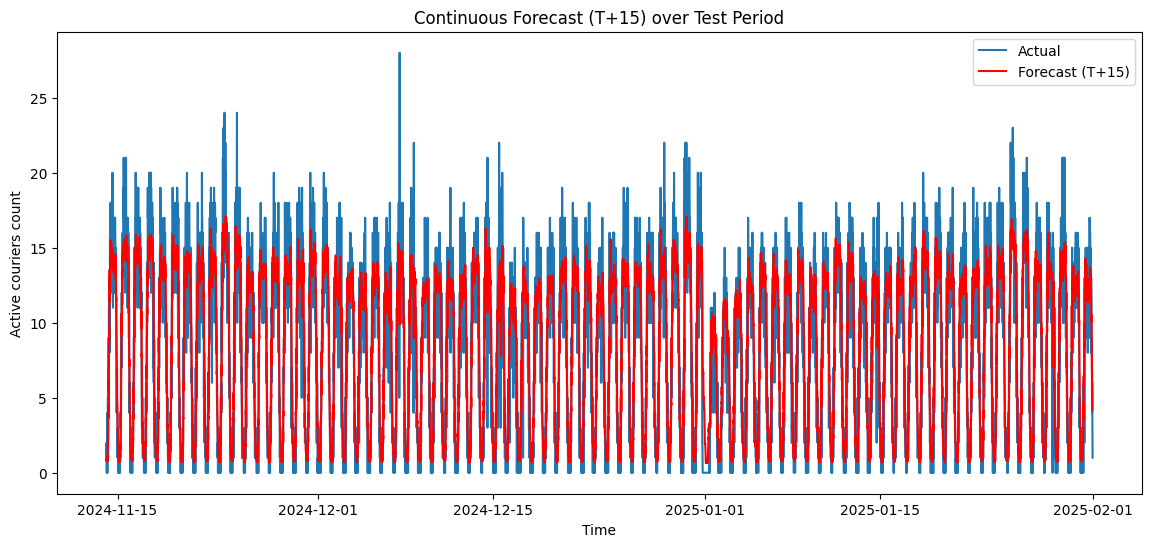

12:49:30 - cmdstanpy - INFO - Chain [1] start processing
12:49:39 - cmdstanpy - INFO - Chain [1] done processing


MAE: 1.669, RMSE: 2.240


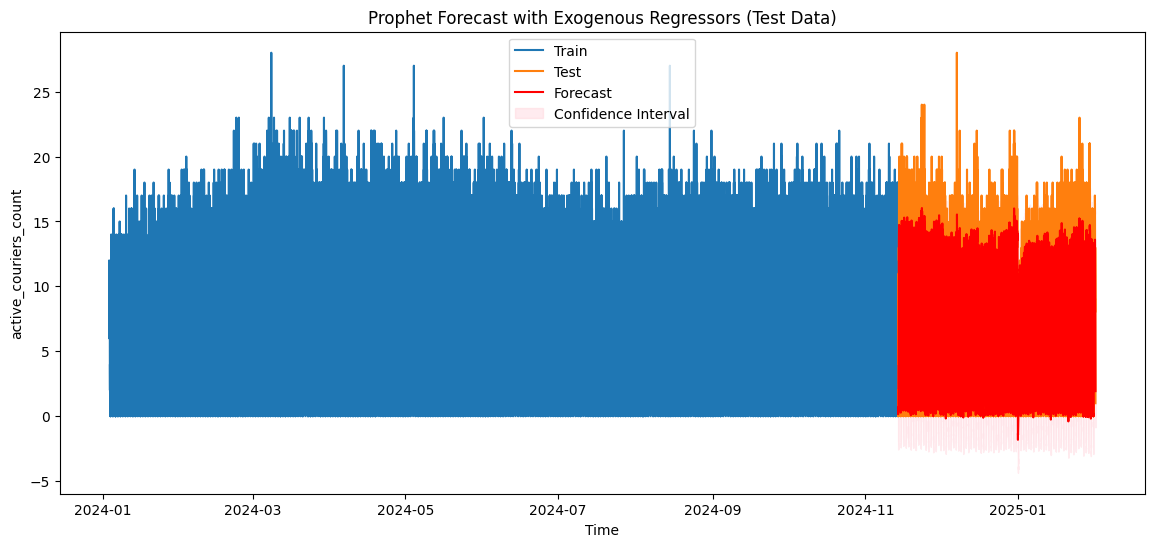

Selected Model for 4723: LightGBM
Choosing method for 4743
100%|██████████| 50/50 [02:51<00:00,  3.44s/trial, best loss: 2.618991104925925] 
Best hyperparameters for multi-step LightGBM: {'max_depth': 3, 'learning_rate': np.float64(0.1659412807271177), 'n_estimators': 307, 'subsample': np.float64(0.9981003560933386), 'colsample_bytree': np.float64(0.7229851250856452), 'min_child_samples': 8, 'reg_alpha': np.float64(7.4705767377766605), 'reg_lambda': np.float64(0.00964335831830927)}
RMSE on test set: 2.2683500810153667, MAE: 1.7026830812201048


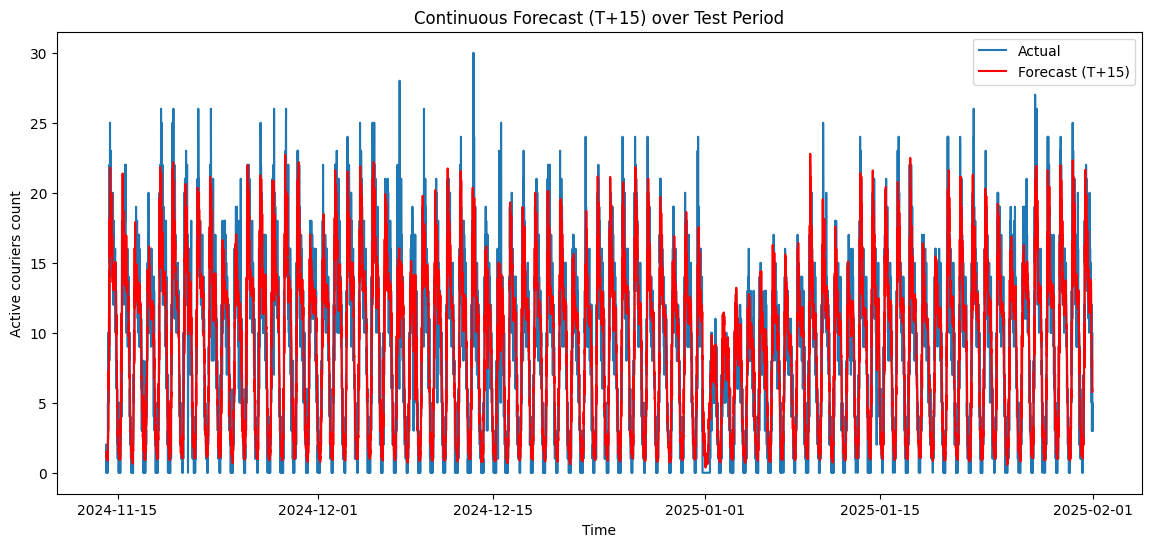

12:52:55 - cmdstanpy - INFO - Chain [1] start processing
12:53:03 - cmdstanpy - INFO - Chain [1] done processing


MAE: 1.983, RMSE: 2.563


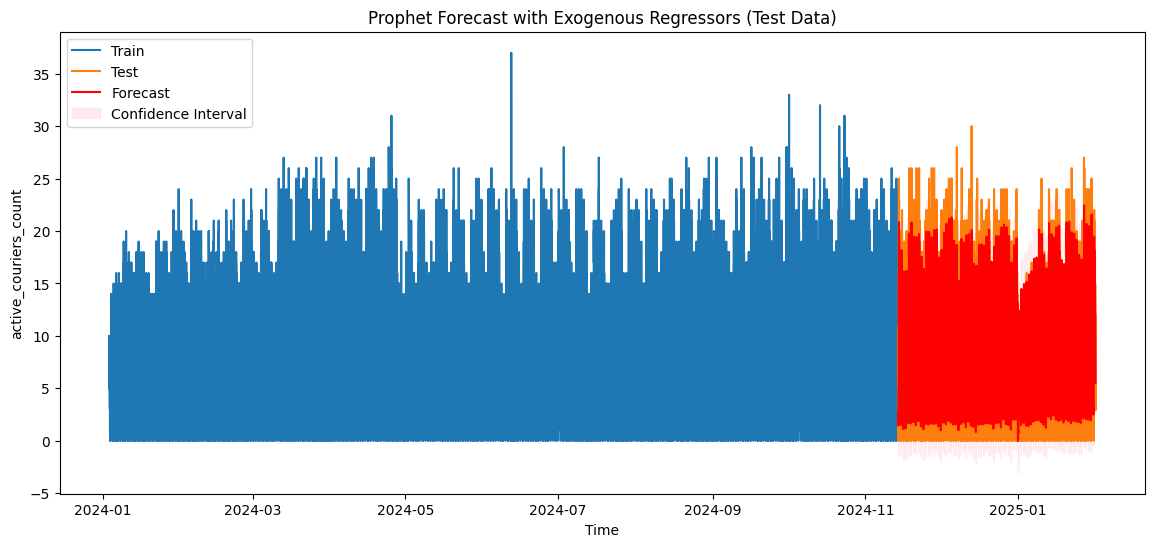

Selected Model for 4743: LightGBM
Choosing method for 4755
 28%|██▊       | 14/50 [00:54<02:19,  3.88s/trial, best loss: 2.1946479150071294]


KeyboardInterrupt: 

In [13]:
for n in unique_N:
    print(f"Choosing method for {n}")
    df_n_one = df_filtered[df_filtered['N'] == n]
    df_n_light = df_n_one.copy()
    split_index = int(0.8 * len(df_n_light))
    df_n_light = df_n_light.set_index('date_group')
    df_n_light = df_n_light.sort_index()
    split_date = df_n_light.index[split_index]
    if pd.to_datetime(df_n_light.index.max().date()) == pd.to_datetime('2025-01-31'):
        df_n_light['active_couriers_count'] = df_n_light['active_couriers_count'].astype('int')
        df_n_light = df_n_light.drop(columns=['N'])
        df_n_light['hour'] = df_n_light.index.hour
        df_n_light['minute'] = df_n_light.index.minute
        df_n_light['dayofweek'] = df_n_light.index.dayofweek
        df_n_light['lag_4'] = df_n_light['active_couriers_count'].shift(4)
        df_n_light['lag_three_hours'] = df_n_light['active_couriers_count'].shift(1, freq='3h')
        df_n_light['hour_sin'] = np.sin(2 * np.pi * df_n_light['hour'] / 24)
        df_n_light['rolling_mean_1h'] = df_n_light['active_couriers_count'].shift(4).rolling(window=4).mean()
        df_n_light['rolling_std_1h'] = df_n_light['active_couriers_count'].shift(4).rolling(window=4).std()
        df_n_light['rolling_mean_3h'] = df_n_light['active_couriers_count'].shift(4).rolling(window=12).mean()
        df_n_light['rolling_std_3h'] = df_n_light['active_couriers_count'].shift(4).rolling(window=12).std()


        lgb_features = ['hour', 'minute', 'dayofweek', 'hour_sin', 
                        'lag_three_hours', 'lag_4', 'rolling_mean_1h', 'rolling_std_1h',
                        'rolling_mean_3h', 'rolling_std_3h', 'active_couriers_count']
        input_steps = 4 
        forecast_steps = 4 
        final_model, sample_times, Y_test, pred_test, forecast_series, lgb_mae, lgb_rmse = train_lightgbm_multi_step_model(
            df_n_light, 'active_couriers_count', input_steps, forecast_steps, split_date, lgb_features, max_evals=50, plot=True
        )

        exog_features = ['hour', 'minute', 'dayofweek', 'hour_sin', 
                        'lag_three_hours', 'lag_4', 'rolling_mean_1h', 'rolling_std_1h',
                        'rolling_mean_3h', 'rolling_std_3h']
        df_n_prophet = df_n_light.dropna().reset_index()
        df_n_prophet['date_group'] = pd.to_datetime(df_n_prophet['date_group'])
        df_n_prophet.set_index('date_group', inplace=True)
        prophet_model, actual, yhat, prophet_mae, prophet_rmse  = train_prophet_model_with_exog(
            df_n_prophet, 'active_couriers_count', split_date, extra_regressors=exog_features, plot=True
        )

        if lgb_rmse < prophet_rmse:
            best_model = "LightGBM"
            result = {
                'N': n,
                'model': best_model,
                'rmse': lgb_rmse,
                'mae': lgb_mae,
                'split_date': split_date
            }
            # with open(f'lightgbm_model_{n}.pkl', 'wb') as f:
            #     pickle.dump(final_model, f)
            # print(f"LightGBM model for N={n} saved as lightgbm_model_{n}.pkl")

        else:
            best_model = "Prophet"
            result = {
                'N': n,
                'model': best_model,
                'rmse': prophet_rmse,
                'mae': prophet_mae,
                'split_date': split_date
            }
            # with open(f'prophet_model_{n}.pkl', 'wb') as f:
            #     pickle.dump(prophet_model, f)
            # print(f"Prophet model for N={n} saved as prophet_model_{n}.pkl")

        print(f"Selected Model for {n}: {best_model}")
        # save_to_csv(result, 'data_2/forecast.csv', header=False)
    else:
        print(f"Closed DS {n}")
        result = {
                'N': n,
                'model': 'no-model',
                'rmse': '-',
                'mae': '-',
                'split_date': '-'
            }
        # save_to_csv(result, 'data_2/forecast.csv', header=False)

## Работа в реальном времени

1. Загружаем модель из сохранённого файла с помощью pickle
2. Каждые час поступают новые данные за последний час – значения за 15, 30, 45 и 60 минут назад, которые добавляются к вашему историческому временному ряду
3. Исходя из новых данных подготовим новые фичи (вычисление всех экзогенных переменных).
4. Прогнозирование c Prophet или Lightgbm: Вызываем model.predict() на новом future DataFrame, который включает даты (и экзогенные переменные). Модель выдаёт прогноз для каждого будущего временного шага (например, +15, +30, +45, +60 минут).
5. Полученные прогнозные сохраняются для дальнейшего анализа в файле excel/csv.

Каждую неделю мы переобучаем модель, используя также все новые данные

<b>Входные данные</b>:
1. Все исторические данные сохранены например в файл csv, куда постоянно добавляются новые данные
2. Модель Prophet для каждого ТТ

<b>Выходные данные</b>:
1. Прогноз колва активных курьеров через 15, 30, 45 и 60 минут



In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
import mysql.connector
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error

# -------------------------
# COMMON FUNCTION: Retrieve new data from MySQL.
def get_new_data():
    """
    Connects to MySQL and retrieves new data from the table.
    The query aggregates active couriers for four intervals (last 15, 15-30, 30-45, 45-60 minutes)
    for each trading point (N). It returns a DataFrame with the column 'ds' (datetime) as index
    and 'active_couriers_count'.
    """
    conn = mysql.connector.connect(
        host='your_host',
        user='your_user',
        password='your_password',
        database='your_database'
    )
    query = """
    WITH intervals AS (
        SELECT 
            NOW() AS end_time,
            DATE_SUB(NOW(), INTERVAL 15 MINUTE) AS start_time
        UNION ALL
        SELECT 
            DATE_SUB(NOW(), INTERVAL 15 MINUTE) AS end_time,
            DATE_SUB(NOW(), INTERVAL 30 MINUTE) AS start_time
        UNION ALL
        SELECT 
            DATE_SUB(NOW(), INTERVAL 30 MINUTE) AS end_time,
            DATE_SUB(NOW(), INTERVAL 45 MINUTE) AS start_time
        UNION ALL
        SELECT 
            DATE_SUB(NOW(), INTERVAL 45 MINUTE) AS end_time,
            DATE_SUB(NOW(), INTERVAL 60 MINUTE) AS start_time
    )
    SELECT 
        i.end_time AS date_group,
        t.N,
        COUNT(DISTINCT t.id_courier) AS active_couriers_count
    FROM Reports_data.Report.report_zakaz_tbl t
    JOIN intervals i
      ON t.date_delivery_start BETWEEN i.start_time AND i.end_time
    GROUP BY i.end_time, t.N
    ORDER BY t.N, i.end_time;
    """
    new_data = pd.read_sql(query, conn)
    conn.close()
    
    return new_data

# -------------------------
# FEATURE ENGINEERING FUNCTION (including lag and rolling features) LIGHTGBM
def add_features(df, target_col='active_couriers_count'):
    df = df.copy()
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    df['dayofweek'] = df.index.dayofweek
    df['hour_sin'] = np.sin(2 * np.pi * df.index.hour / 24)
    
    df['lag_4'] = df[target_col].shift(4)
    df['lag_three_hours'] = df[target_col].shift(12)
    
    df['rolling_mean_1h'] = df[target_col].shift(4).rolling(window=4).mean()
    df['rolling_std_1h'] = df[target_col].shift(4).rolling(window=4).std()
    df['rolling_mean_3h'] = df[target_col].shift(4).rolling(window=12).mean()
    df['rolling_std_3h'] = df[target_col].shift(4).rolling(window=12).std()
    
    return df

# -------------------------
# FUNCTION FOR PREPARING FUTURE DATA WITH LAG FEATURES (for Prophet)
def prepare_future_with_lags(updated_data, future, target_col='active_couriers_count'):
    """
    Объединяет обновлённые исторические данные (с рассчитанными фичами) с future DataFrame,
    пересчитывает лаговые и rolling-признаки для всего объединённого набора, 
    а затем извлекает future (новые даты).
    """
    combined = pd.concat([updated_data, future])
    combined = combined.sort_index()

    combined['hour'] = combined['ds'].dt.hour
    combined['minute'] = combined['ds'].dt.minute
    combined['dayofweek'] = combined['ds'].dt.dayofweek
    combined['hour_sin'] = np.sin(2 * np.pi * combined['ds'].dt.hour / 24)
    combined['lag_4'] = combined[target_col].shift(4)
    combined['lag_three_hours'] = combined[target_col].shift(12)
    combined['rolling_mean_1h'] = combined[target_col].shift(4).rolling(window=4).mean()
    combined['rolling_std_1h'] = combined[target_col].shift(4).rolling(window=4).std()
    combined['rolling_mean_3h'] = combined[target_col].shift(4).rolling(window=12).mean()
    combined['rolling_std_3h'] = combined[target_col].shift(4).rolling(window=12).std()
    
    future_with_lags = combined.loc[future.index].copy()
    return future_with_lags


# PROPhet FORECASTING FUNCTION
def forecast_task_prophet():
    with open('/path/to/prophet_model_tt.pkl', 'rb') as f:
        model = pickle.load(f)
    
    new_data = get_new_data()
    new_data = new_data.rename(columns={'date_group': 'ds'})
    new_data['ds'] = pd.to_datetime(new_data['ds'])
    new_data.set_index('ds', inplace=True)
    historical_data = pd.read_csv('/path/to/historical_data.csv', parse_dates=['ds'])
    historical_data.set_index('ds', inplace=True)
    updated_data = pd.concat([historical_data, new_data]).sort_index()
    updated_data = add_features(updated_data, target_col='active_couriers_count')
    
    forecast_horizon = 4  
    future = model.make_future_dataframe(periods=forecast_horizon, freq='15T', include_history=False)
    future_with_lags = prepare_future_with_lags(updated_data, future, target_col='active_couriers_count')
    forecast = model.predict(future_with_lags)
    # forecast.to_csv('/path/to/forecast_prophet.csv', index=False)
    # print("Prophet forecast saved to /path/to/forecast_prophet.csv")
    return forecast

# LIGHTGBM FORECASTING FUNCTION
def prepare_input_vector(df, target_col='active_couriers_count', input_steps=4, feature_cols=None):
    """
    Prepares an input vector for forecasting LightGBM based on the last input_steps observations.
    If feature_cols is not provided, uses a default set of features.
    """
    if feature_cols is None:
        feature_cols = ['hour', 'minute', 'dayofweek', 'hour_sin',
                        'lag_three_hours', 'lag_4',
                        'rolling_mean_1h', 'rolling_std_1h',
                        'rolling_mean_3h', 'rolling_std_3h',
                        target_col]
    input_window = df.iloc[-input_steps:][feature_cols].values.flatten()
    col_names = [f"{feat}_lag_{lag}" for feat in feature_cols for lag in range(input_steps, 0, -1)]
    input_df = pd.DataFrame([input_window], columns=col_names)
    return input_df

def forecast_task_lightgbm():
    with open('/path/to/final_lightgbm_model.pkl', 'rb') as f:
        final_model_full = pickle.load(f)
    
    new_data = get_new_data()
    new_data['date_group'] = pd.to_datetime(new_data['date_group'])
    new_data.set_index('date_group', inplace=True)
    historical_data = pd.read_csv('/path/to/historical_data.csv', parse_dates=['ds'], index_col='ds')
    updated_data = pd.concat([historical_data, new_data]).sort_index()
    updated_data = add_features(updated_data, target_col='active_couriers_count')
    input_steps = 4  
    lgb_features = ['hour', 'minute', 'dayofweek', 'hour_sin',
                    'lag_three_hours', 'lag_4',
                    'rolling_mean_1h', 'rolling_std_1h',
                    'rolling_mean_3h', 'rolling_std_3h',
                    'active_couriers_count']
    input_df = prepare_input_vector(updated_data, target_col='active_couriers_count', input_steps=input_steps, feature_cols=lgb_features)
    
    new_preds = final_model_full.predict(input_df)
    
    forecast_times = pd.to_datetime(updated_data.index[-1]) + pd.to_timedelta(np.arange(15, 15*(len(new_preds[0])+1), 15), unit='T')
    forecast_series = pd.DataFrame(new_preds, columns=[f"+{15*(i+1)}min" for i in range(len(new_preds[0]))], index=forecast_times)
    # forecast_series.to_csv('/path/to/forecast_lightgbm.csv', index=True)
    # print("LightGBM forecast saved to /path/to/forecast_lightgbm.csv")
    return forecast_series

model_type = 'prophet'  # or 'lightgbm'
if model_type == 'prophet':
    forecast_results = forecast_task_prophet()
elif model_type == 'lightgbm':
    forecast_results = forecast_task_lightgbm()
else:
    raise ValueError("Unknown model type.")

